In [1]:
%load_ext autoreload
%autoreload 2
import bokeh
from bokeh.models import ColumnDataSource, Label, Text, Span, HoverTool #, Range1d#, LabelSet
from bokeh.plotting import figure, output_file, show
import pandas as pd; pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
from datetime import datetime
from pprint import pprint as pp
import warnings; warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact, IntSlider
import ipywidgets as widgets
import arrow
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import scipy.fftpack

import time
import dmyplant2

#import dmyplant2
from dmyplant2 import (
    cred, MyPlant, Engine, 
    FSMOperator, filterFSM, FSM_splot, FSM_VLine, FSM_add_Notations, FSM_add_Alarms, FSM_add_Warnings, 
    bokeh_show, dbokeh_chart, add_dbokeh_vlines, get_cycle_data2, disp_result, disp_alarms, disp_warnings,
    cvset, load_data, get_cycle_data, get_cycle_data2, figures)
    
cred()
mp = MyPlant(3600)
Engine._list_cached_validations();
#mp._fetch_installed_base(); # refresh local installed fleet database

In [2]:
def sfun(x):
    return all([ ("BMW Landshut 4.10" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T;

In [3]:
motor = fleet.iloc[3]
modes = ['undefined','OFF','MAN','AUTO']
success = [True,False]
#success = [True]
motor['IB Site Name'] + ' ' + motor['Engine ID'], modes, success

('BMW Landshut 4.10 M4', ['undefined', 'OFF', 'MAN', 'AUTO'], [True, False])

In [4]:
e=Engine.from_fleet(mp,motor)
fsm = FSMOperator(e, p_from=e['Commissioning Date'], p_to=datetime.now())

In [5]:
fsm.run0(enforce=True, silent=False, debug=False)
fsm.run1(silent=False, successtime=300, debug=False) # run Finite State Machine

FSM: 100%|█████████████████████| 141604/141604 [00:28<00:00, 5028.11 messages/s]


In [6]:
fsm.run2(silent = False)

FSM: 100%|███████████████████████████| 1278/1278 [01:14<00:00, 17.22 messages/s]


In [7]:
rdf = fsm.starts
rda = rdf[:].reset_index(drop='index')
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))].reset_index(drop='index')
display(HTML(pd.DataFrame.from_dict(e.dash, orient='index').T.to_html(escape=False, index=False)))
#rda[filterFSM.run2filter_content].round(2)
print(f"Starts: {rdf.shape[0]}, Successful: {rdf[rdf['success'] == True].shape[0]}, Failed: {rdf[rdf['success'] == False].shape[0]} => {rdf[rdf['success'] == True].shape[0]/rdf.shape[0]*100.0:3.1f}%")

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Na…

Starts: 1278, Successful: 907, Failed: 371 => 71.0%


In [8]:
rda[filterFSM.run2filter_content].round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,targetload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,0,True,undefined,265.13,4.41,14.31,7.97,25.82,135.41,453.05,4491.92,0.74,132875.7,127.53,0.0,49.41,0,4
1,1,False,AUTO,350.70,4.64,15.0,49.26,12.5,127.54,559.64,4274.84,0.74,119.26,,,,1,3
2,2,False,AUTO,325.17,4.03,15.22,7.46,11.98,45.38,409.23,,,,,,,1,0
3,3,True,AUTO,265.01,4.74,13.91,7.67,19.33,134.62,445.26,4487.42,0.74,109692.96,96.69,0.0,49.47,0,7
4,4,False,AUTO,255.37,,,,,,255.37,,,,,,,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,1273,False,AUTO,261.18,4.15,15.76,57.96,9.37,45.62,394.03,1264.24,0.62,117.62,,,,0,0
1274,1274,True,AUTO,261.19,6.17,13.0,6.93,16.88,214.4,518.57,3156.0,0.33,32042.65,122.46,10.01,49.51,0,6
1275,1275,True,AUTO,261.60,5.24,14.91,7.48,21.0,214.59,524.83,3162.0,0.33,263737.92,112.63,9.96,49.25,0,3
1276,1276,True,AUTO,261.68,4.74,18.18,7.27,20.6,213.7,526.17,3153.14,0.33,418380.9,92.72,9.95,49.52,0,7


In [9]:
rdd = rda[rda['loadramp'] < 0.0]
rdd[filterFSM.run2filter_content].round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,targetload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings


In [10]:
fsm.results['starts'][0];

In [11]:
#rdb = rda[(rda['mode'].isin(['AUTO','MAN'])) & ((rda['count_alarms'] > 0) | (rda['count_warnings'] > 0))]
#rdb = rda[rda['synchronize'] < 15.0]
rdb = rda
#rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2)

,startpreparation,speedup,idle,synchronize,loadramp,targetload,ramprate,cumstarttime,targetoperation,rampdown,coolrun,runout
count,1278.00,1175.00,1155.00,1138.00,1075.00,978.00,978.00,1278.00,959.00,940.00,939.00,822.00
mean,245.90,16.38,17.60,18.45,165.25,3529.19,0.49,437.15,65343.82,85.61,128.22,48.91
std,71.46,2.63,69.47,12.39,59.69,870.77,0.19,146.90,148537.88,37.51,1486.70,1.99
min,0.10,3.02,0.10,0.40,5.66,12.00,0.05,0.10,-2.81,0.01,0.00,8.17
25%,261.11,14.91,6.75,10.49,134.99,3152.80,0.33,414.61,2341.56,76.12,0.00,48.63
50%,262.47,15.82,7.43,16.84,186.63,3158.53,0.33,470.27,7526.47,96.48,9.98,49.22
75%,263.38,17.48,8.17,20.14,214.20,4496.35,0.74,519.15,58497.95,108.62,10.01,49.57
max,1133.98,35.56,1920.20,81.96,400.42,4540.57,1.06,2097.94,1624506.48,129.97,29666.25,52.25


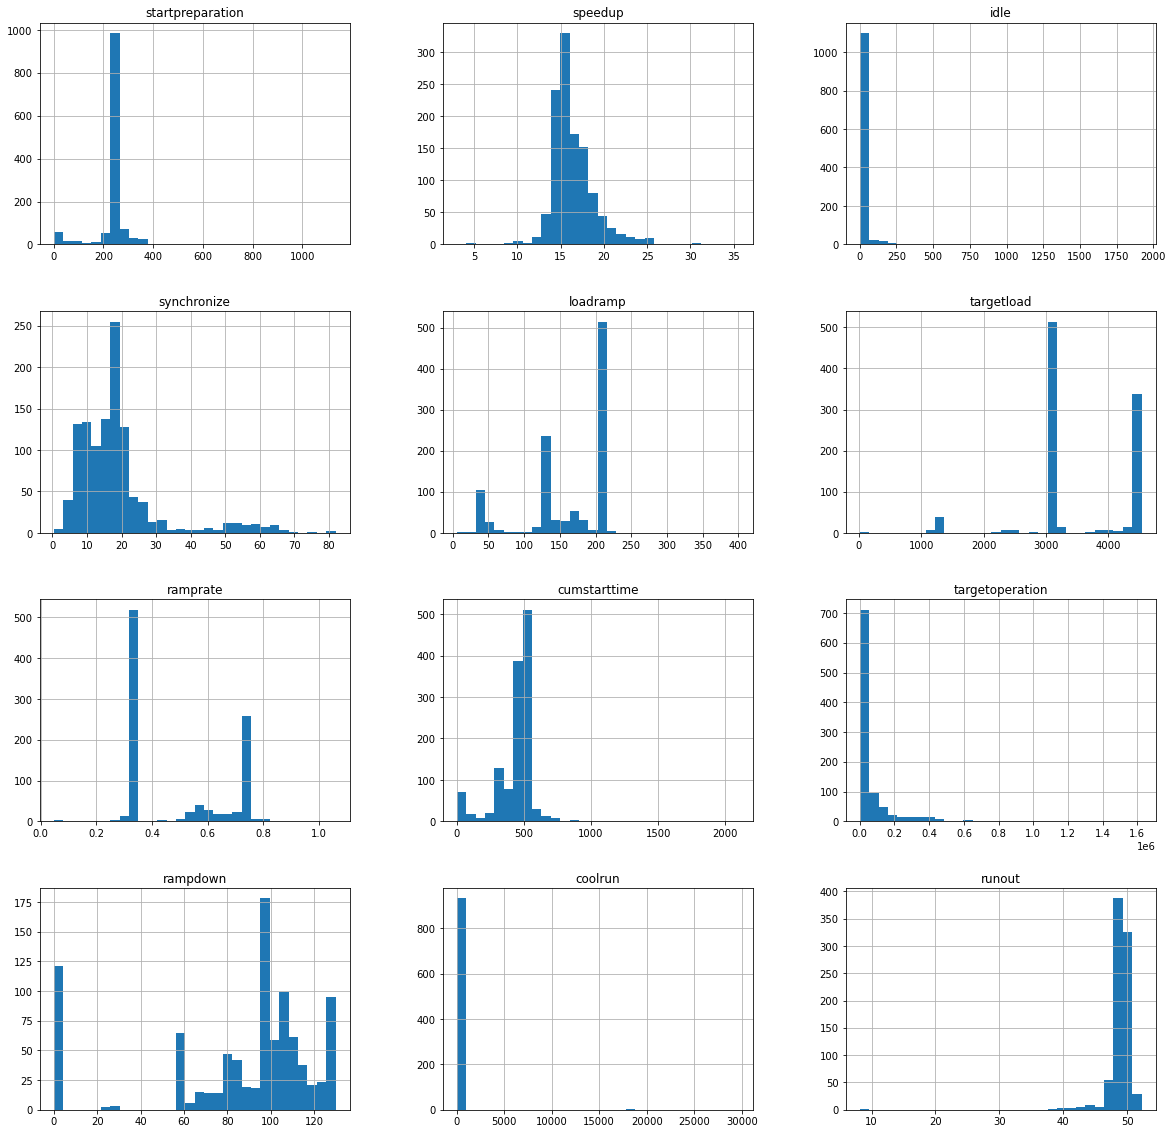

In [13]:
vec = ['startpreparation','speedup','idle','synchronize','loadramp','targetload','ramprate','cumstarttime','targetoperation','rampdown','coolrun','runout']
display(_=rdb[vec].hist(bins=30,figsize=(20,20)))
#ax_list[0][2].set_xlim((0,10))
#display(rdb[vec].hist(bins=30,figsize=(20,20)))
display(rdb[vec].describe().round(2))

In [14]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success'])].copy()
rde['datetime'] = pd.to_datetime(rde['starttime'])
dfigsize = (18,12)
dset = [
    {'col':['cumstarttime'],'ylim':(-400,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-20,300)},
    {'col':['startpreparation'],'ylim':(-600,300)},
    {'col':['hochlauf'],'ylim':(-100,200), 'color':'orange'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,3)},
    {'col':['no'],'ylim':(-100,10000),'color':'black'},
    {'col':['maxload'],'ylim':(500,5000) }
]
ftitle = f"{fsm._e}"
fig = dbokeh_chart(rde, dset, style='both', figsize=dfigsize ,title=ftitle);
bokeh_show(fig)
del(fig)

In [15]:
vset = ['Various_Values_SpeedAct','Power_PowerAct','Hyd_PressCrankCase','Hyd_PressOilDif','Hyd_PressOil','Hyd_TempOil']
dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red'},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'},
    {'col':['Hyd_PressCrankCase'],'ylim': [-100, 100], 'color':'orange'},
    {'col':['Hyd_PressOilDif'],'ylim': [0, 2], 'color':'black'},
    {'col':['Hyd_PressOil'],'ylim': [0, 10], 'color':'brown'},
    {'col':['Hyd_TempOil'],'ylim': [0, 110], 'color':'#2171b5'}
]


In [16]:
rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,targetload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
580,580,True,AUTO,162.34,5.13,15.62,136.7,0.4,214.15,534.34,3150.0,0.33,79454.65,95.74,9.97,49.77,0,2
677,677,True,AUTO,343.76,5.14,4.74,317.34,1.52,36.42,708.91,1180.33,0.72,7515.56,128.3,9.99,49.35,0,9
536,536,True,AUTO,263.10,4.93,18.83,218.92,1.72,186.46,693.97,2253.98,0.27,1678.44,58.09,9.99,50.15,0,2
967,967,False,AUTO,318.62,5.05,13.6,73.98,1.92,47.65,460.82,1299.51,0.61,283.27,27.26,10.06,44.24,0,1
997,997,False,AUTO,262.95,5.24,19.08,121.84,2.22,213.9,625.23,3161.62,0.33,222.61,76.18,10.08,46.36,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,1224,False,MAN,284.56,4.85,9.78,,,,299.19,,,,,,,0,0
1230,1230,False,AUTO,261.87,7.98,,,,,269.85,,,,,,,1,0
1231,1231,False,AUTO,3.02,,,,,,3.02,,,,,,,1,0
1256,1256,False,AUTO,14.60,,,,,,14.60,,,,,,,0,0


In [21]:
def f(x=0):
    global vv; vv = x; startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')} CumStart: {startversuch['cumstarttime']:0.1f}"
    display(HTML(ftitle));
    disp_result(startversuch)
interact(f, x = IntSlider(0, 0, rdb.shape[0]-1 , 1, layout=widgets.Layout(width='90%')));

HTML(value='1320072 BMW Landshut 4.10 M4 ----- Start 0 undefined | SUCCESS | 2019-01-09 00:52:08 CumStart: 453…

no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,targetload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,True,undefined,265.13,4.410999,14.314,7.965999,25.819,135.411,453.050998,4491.918,0.737166,132875.697999,127.533,0.0,49.409999,0,4


<function __main__.f(x=0)>

In [31]:
# PLotter
for f in figures:
    print(f, end=', ')
data = pd.DataFrame([])
plotdef = ['actors','lubrication']
vset = []
for p in plotdef:
    dset = figures[p]
    vset += cvset(mp,dset)
vset = list(set(vset))
#pp(vset)
for doplot in plotdef:
#for doplot in ['actors']:
    dmaxlength = None
    dminlength = None
    #dmaxlength = 1200
    #dminlength = 200000
    dset = figures[doplot]
    startversuch = rdb.iloc[vv]; 
    try:
        data = get_cycle_data2(fsm, startversuch, max_length=dmaxlength, min_length=dminlength, cycletime=1, silent=True, p_data=vset)
        data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
        fig = FSM_splot(fsm, startversuch, data, dset, figsize=(18,10))
        fig = FSM_add_Notations(fig, fsm, startversuch)
        disp_alarms(startversuch)
        disp_warnings(startversuch)
        fig = FSM_add_Alarms(fig, fsm, startversuch)
        fig = FSM_add_Warnings(fig, fsm, startversuch)
        bokeh_show(fig)
    except Exception as err:
        print(err)

starts_overview, actors, lubrication, von: 09.01.2019 00:52:07 bis: 10.01.2019 13:57:13


state,severity,Number,date,message
targetoperation,700,1345,09.01.2019 01:03:29,Measuring signal failure Wärmemenge aktuell Notkühlkreis
targetoperation,700,3160,09.01.2019 06:20:03,Gas volume measuring signal failure
targetoperation,700,1196,09.01.2019 08:40:09,Störung Trafoüberwachungsrelais
targetoperation,700,3160,10.01.2019 08:04:42,Gas volume measuring signal failure


von: 09.01.2019 00:52:07 bis: 10.01.2019 13:57:13


state,severity,Number,date,message
targetoperation,700,1345,09.01.2019 01:03:29,Measuring signal failure Wärmemenge aktuell Notkühlkreis
targetoperation,700,3160,09.01.2019 06:20:03,Gas volume measuring signal failure
targetoperation,700,1196,09.01.2019 08:40:09,Störung Trafoüberwachungsrelais
targetoperation,700,3160,10.01.2019 08:04:42,Gas volume measuring signal failure


In [ ]:
sv = startversuch.to_dict()
x0 = sv['startstoptiming'']['loadramp'][-1]['start']
y0 = 0.0
default_ramp_duration = 100.0 / fsm._e['rP_Ramp_Set']
x1 = x0 + pd.Timedelta(default_ramp_duration, unit='sec')
y1 = fsm._e['Power_PowerNominal']
x0,x1,y0,y1, default_ramp_duration

In [ ]:
from bokeh.models import Span
ramp = fig.line(x=[x0,x1],y=[y0,y1], y_range_name='0', line_color='green', line_dash='dotted', line_alpha=0.4, line_width=4)
fig.add_layout(ramp)

c = fig.circle(x0,y0)
fig.add_layout(c)

this = Span(location=x0,dimension='height', y_range_name='0',line_color='blue', line_dash='solid', line_alpha=0.4, line_width=4)
fig.add_layout(this) 


In [ ]:
bokeh_show(fig)

In [ ]:
fsm.starts.iloc[v].to_dict()

In [ ]:
for i, v in enumerate(fsm.runlogdetail(startversuch, statechanges_only=True)):
    print(f"{i:3} {v}")

In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)